In [422]:
import pickle
import numpy as np
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import trimesh
from matplotlib import cm, colors
import datetime

VELOCITY_SCALE_FACTOR = 100 / 6  # for stepsize = 0.06 ms
DIST_THRES = 10.12 # the smaller the more fragments
MASS_PER_PARTICLE = 0.0024
MAX_FRAGMENT_SIZE = 100
n_steps = 100

def compute_particle_mask(init_particle_pos, charge_weight):
    
    thres = np.sqrt(charge_weight) * 150
    center_mask =  (init_particle_pos[:, 0] < thres) & (init_particle_pos[:, 0] > -thres) & (init_particle_pos[:, 1] < thres) & (init_particle_pos[:, 1] > -thres)
    
    return center_mask
    
def compute_fragment(particle_position, dist_thres=10.2, max_fragment_size=100):
    kdt = KDTree(particle_position)
    indices = kdt.query_radius(particle_position, r=dist_thres)
    visited = set()
    fragments = []
    particles_in_fragments = set()

    for idx, neighbors in enumerate(indices):
        if idx not in visited and idx not in particles_in_fragments:
            new_fragment = set()
            stack = [idx]
            while stack:
                current = stack.pop()
                if current not in visited and current not in particles_in_fragments:
                    visited.add(current)
                    new_fragment.add(current)
                    stack.extend([n for n in indices[current] if n not in visited and n not in particles_in_fragments])

            if len(new_fragment) <= MAX_FRAGMENT_SIZE:
                fragments.append(new_fragment)
                particles_in_fragments.update(new_fragment)
                
    #print('aaa',[particle_position[list(new_fragment)] for new_fragment in fragments if len(new_fragment)>10])
    
    return  fragments

def compute_fragment_property(particle_position, particle_last_position, fragments):
    centres, masses, diameters, vels = [], [], [], []
    
    for idx, fragment in enumerate(fragments):
        fragment_positions = particle_position[list(fragment)] 
        fragment_centre = fragment_positions.mean(axis=0)
        fragment_mass = len(fragment)*MASS_PER_PARTICLE

        # calculate spatial size (diameter of the fragment)
        if len(fragment) >= 2:  # cdist requires at least 2 points
            distances = cdist(fragment_positions, fragment_positions)
            fragment_diameter = distances.max()
        else:
            fragment_diameter = 10  # single element diameter

        # calculate fragment speed
        particle_vel = particle_position - particle_last_position
        fragment_vels = particle_vel[list(fragment)] * VELOCITY_SCALE_FACTOR
        fragment_vel = np.mean(fragment_vels, axis=0)
        
        centres.append(fragment_centre)
        masses.append(fragment_mass)
        diameters.append(fragment_diameter)
        vels.append(fragment_vel)
    
    # Conver list to np array
    centres = np.array(centres)
    masses = np.array(masses)
    diameters = np.array(diameters)
    vels = np.array(vels)
    
    return centres, masses, diameters, vels


def save_property_csv(fragments_centre, fragments_mass, fragments_diameter, fragments_vel, case, step, savename=str(property_dir / f'fragments_properties_step_{step}.csv')):
    metadata = {
        'Date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'Case': case,
        'Step': step,      
    }
    metadata_str = "\n".join([f"# {key}: {value}" for key, value in metadata.items()]) + '\n'
    
    data = {
        'Centre X': fragments_centre[:, 0],
        'Centre Y': fragments_centre[:, 1],
        'Centre Z': fragments_centre[:, 2],
        'Mass': fragments_mass,
        'Diameter': fragments_diameter,
        'Velocity X': fragments_vel[:, 0],
        'Velocity Y': fragments_vel[:, 1],
        'Velocity Z': fragments_vel[:, 2],
    }
    df = pd.DataFrame(data)
    
    # Save DataFrame to CSV with metadata
    with open(savename, 'w') as f:
        f.write(metadata_str)
    df.to_csv(savename, index=False, mode='a', header=True)
    
def compute_mass_distribution(fragments_mass, fragments_diameter, cut_thres=[10, 30, 50, 80]):
    mass_distribution = []
    
    # the first range
    mask = fragments_diameter < cut_thres[0]
    mass = fragments_mass[mask].sum()
    mass_distribution.append(mass)
    
    # subsequent range
    for i in range(len(cut_thres)-1):
        mask = (fragments_diameter >= cut_thres[i]) & (fragments_diameter < cut_thres[i+1])
        mass = fragments_mass[mask].sum()
        mass_distribution.append(mass)
    
    # the last range
    mask = fragments_diameter >= cut_thres[-1]
    mass = fragments_mass[mask].sum()
    mass_distribution.append(mass)
    
    return mass_distribution

def plot_mass_distribution_bar(mass_distribution, savename='/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/temp/test.png'):
    x_labels = ['0-10', '10-30', '30-50', '50-80', '>80']
    
    # Create a DataFrame to hold the data
    df = pd.DataFrame({
        'Categories': x_labels,  # Repeat the labels to create two groups
        'Values': mass_distribution,     # Concatenate the data for both groups
        'Data': ['dummy']*len(mass_distribution)  # Group label for each bar
    })

    fig, ax = plt.subplots(figsize=(7, 5))

    # Use Seaborn's barplot to create a grouped bar chart
    sns.set_theme(style='ticks')
    sns.barplot(data=df, x='Categories', y='Values', hue='Data')

    # Change font size of tick labels
    ax.tick_params(labelsize=20)

    # Change font size of axis labels
    ax.set_ylabel('Mass (kg)', fontsize=24)
    ax.set_xlabel('Fragment size (mm)', fontsize=24)
    #ax.legend(loc=none, fontsize=20)
    ax.legend_.remove()
    ax.grid(True, linestyle='--')
    ax.set_ylim([0, 30])
    
    # Add annotation for total mass
    total_mass = df['Values'].sum()
    ax.text(0.5, 1.05, f'Total Mass: {total_mass:.2f} kg', ha='center', va='bottom', transform=ax.transAxes, fontsize=20)
    
    plt.savefig(savename, bbox_inches='tight')
    plt.close()

def plot_eps(particle_pos, particle_strain, particle_type, eps_bug_mask, view, savename):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Apply mask for particle type
    mask = particle_type == 1
    particle_strain[mask] = 0

    # Scatter plot colored by strain values
    sc = ax.scatter(particle_pos[~eps_bug_mask, 0], particle_pos[~eps_bug_mask, 1], particle_pos[~eps_bug_mask, 2], s=2, c=particle_strain[~eps_bug_mask], vmin=0, vmax=2, cmap='jet')

    # Setting the aspect ratio of the plot to be equal
    ax.set_box_aspect([np.ptp(a) for a in particle_pos.T])

    # Remove grid, ticks, and labels
    ax.set_title(savename)
    ax.grid(False)
    ax.set_zticklabels([])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('')

    # Hide the Z-axis
    ax.zaxis.line.set_lw(0)
    ax.set_zticks([])

    # Adjust the margin between the axis ticks and labels
    ax.tick_params(axis='both', which='major', pad=8)

    # Adding a colorbar
    cbar = plt.colorbar(sc, orientation='horizontal', pad=0., aspect=70)
    cbar.set_label('Effective Plastic Strain')

    # Changing the view angle
    elev = -90 if 'bot' in view else 90
    ax.view_init(elev=elev, azim=0)

    # Save the plot to a file
    plt.savefig(savename)
    plt.close()

def plot_fragment(masked_particle_position, fragments, fragments_vel, savename):
    positions = masked_particle_position
    fragments_vel = np.linalg.norm(fragments_vel, axis=1)
    norm = colors.Normalize(vmin=np.min(fragments_vel), vmax=np.max(fragments_vel))
    cmap = cm.jet
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=0.5, c='grey', alpha=0.3)

    # Loop over fragments and plot each mesh
    for idx, fragment in enumerate(fragments):
        fragment_positions = positions[list(fragment)]
        fragment_vel = fragments_vel[idx]

        if len(fragment) > 3:
            mesh = trimesh.Trimesh(vertices=fragment_positions, process=True)
            hull = mesh.convex_hull

            # Get the vertices and faces from the mesh
            vertices = hull.vertices
            faces = hull.faces
            color = cmap(norm(fragment_vel))

            # Create a Poly3DCollection from the vertices and faces
            mesh_plot = Poly3DCollection(vertices[faces], edgecolor='k', facecolors=color, linewidths=0.1, alpha=0.9)
            ax.add_collection3d(mesh_plot)

    # Set plot limits
    ax.set_box_aspect([np.ptp(a) for a in positions.T])
    ax.set_xlim(positions[:, 0].min(), positions[:, 0].max())
    ax.set_ylim(positions[:, 1].min(), positions[:, 1].max())
    ax.set_zlim(positions[:, 2].min(), positions[:, 2].max())

    # Set labels
    ax.set_title('Filename')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add color bar
    ax_colorbar = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(fragments_vel)
    cbar = plt.colorbar(mappable, shrink=0.8, aspect=50, cax=ax_colorbar)
    cbar.set_label('fragment velocity (m/s)')
    
    # Save the plot to a file
    plt.savefig(savename)
    plt.close()
    
def compute_max_vel(fragments_vel):
    
    return (np.linalg.norm(fragments_vel, axis=1)).max()

Elapsed time: 1.47 seconds
Elapsed time: 4.03 seconds
Elapsed time: 4.93 seconds
8.23439999999992 25.533600000001755 48.74640000000881


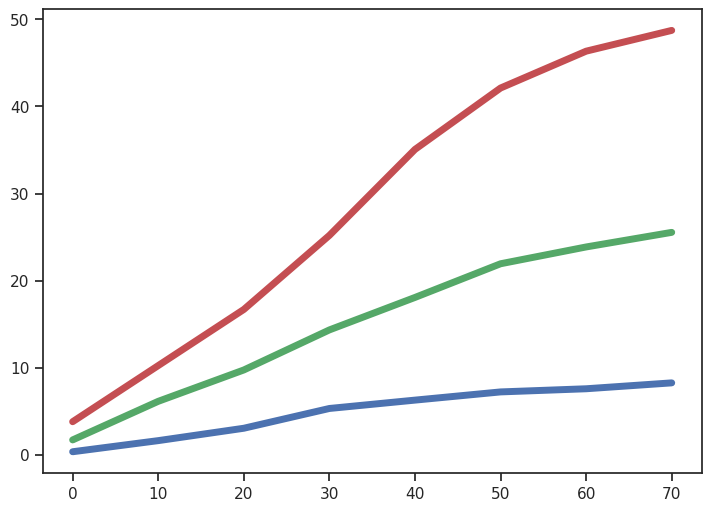

In [421]:
import time
import pickle
import numpy as np
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

DIST_THRES = 10.12 # the smaller the more fragments
MASS_PER_PARTICLE = 0.0024
MAX_FRAGMENT_SIZE = 100
n_steps = 80


def compute_fragment_mass_kdtree(positions):
    kdt = KDTree(positions)
    indices = kdt.query_radius(positions, r=DIST_THRES)
    visited = set()
    fragments = []
    total_mass = 0
    particles_in_fragments = set()

    for idx, neighbors in enumerate(indices):
        if idx not in visited and idx not in particles_in_fragments:
            new_fragment = set()
            stack = [idx]
            while stack:
                current = stack.pop()
                if current not in visited and current not in particles_in_fragments:
                    visited.add(current)
                    new_fragment.add(current)
                    stack.extend([n for n in indices[current] if n not in visited and n not in particles_in_fragments])

            if len(new_fragment) <= MAX_FRAGMENT_SIZE:
                fragments.append(new_fragment)
                total_mass += len(new_fragment) * MASS_PER_PARTICLE
                particles_in_fragments.update(new_fragment)

    return  total_mass, fragments


all_masses = []
cases = ['d3plot2', 'd3plot4','d3plot6']
for case in cases:
    path = f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/input0.4-1ms/{case}.pkl'
    try:
        with open(path, "rb") as file:
            rollout_data = pickle.load(file)
    except FileNotFoundError:
        print(f"File {path} not found.")
        continue

    pred_pos = rollout_data['pred_trajs']
    masses = []
    vel = int(case[-1])
    Bound = np.sqrt(vel) * 150
    center_mask =  (pred_pos[0, :, 0] < Bound) & (pred_pos[0, :, 0] > -Bound) & (pred_pos[0, :, 1] < Bound) & (pred_pos[0, :, 1] > -Bound)
    # mid_index = ((pred_pos[0, :, 1] < Bound+200) & (pred_pos[0, :, 1] > -850)) | ((pred_pos[0, :, 1] < 850) & (pred_pos[0, :, 1] > -Bound-200))
    # z_velocity = (pred_pos[1:, mid_index, 2] - pred_pos[:-1, mid_index, 2])
    # z_velocity = np.partition(z_velocity, -100, axis=1)[:, -100:].mean(axis=1)
    #z_velocity = np.insert(z_velocity, 0, 0)
    
    start_time = time.time()
    steps = np.arange(0, n_steps, 10)
    for step in steps:
        #mid_top_mask = mid_index & (pred_pos[step, :, 2] > (115 + z_velocity[:step].sum()))
        mask = center_mask 
        filtered_positions = pred_pos[step, :, :][mask]

        if filtered_positions.shape[0] > 0:
            mass, fragments = compute_fragment_mass_kdtree(filtered_positions)
            masses.append(mass)
        else:
            print(f"No particles available for computation at step {step}.")
            masses.append(0.0)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    all_masses.append(masses)
    

# 2kg TNT -> 8kg fragments
# 4kg TNT -> 25kg fragments
# 6kg TNT -> 47kg fragments

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['font.size'] = 20

ax = fig.add_subplot(1, 1, 1)
ax.plot(steps, all_masses[0], 'b')
ax.plot(steps, all_masses[1], 'g')
ax.plot(steps, all_masses[2], 'r')
print(all_masses[0][-1], all_masses[1][-1], all_masses[2][-1])

In [424]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import numpy as np
import trimesh
from scipy.spatial.distance import pdist, squareform
from matplotlib import cm, colors
from pathlib import Path
import pandas as pd

# Define the conditions for fragment filtering
start_time = time.time()
case = 'd3plot4'
path = f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/input0.4-1ms/{case}.pkl'

case_dir = Path(f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/temp/{case}_0.4-1ms/')
property_dir = case_dir / 'property'
Path(property_dir).mkdir(parents=True, exist_ok=True)

mass_dir = case_dir / 'mass'
Path(mass_dir).mkdir(parents=True, exist_ok=True)

eps_dir = case_dir / 'eps'
Path(eps_dir).mkdir(parents=True, exist_ok=True)

fragment_dir = case_dir / 'fragment'
Path(fragment_dir).mkdir(parents=True, exist_ok=True)

try:
    with open(path, "rb") as file:
        rollout_data = pickle.load(file)
except FileNotFoundError:
    print(f"File {path} not found.")
    
pred_trajs = rollout_data['pred_trajs']
particle_strains = rollout_data['pred_strains']
particle_type = rollout_data['particle_type']
charge_weight = int(case[-1])
mask = compute_particle_mask(pred_trajs[0], charge_weight)
eps_bug_mask = (pred_trajs[0, :, 0] < 250)&(pred_trajs[0, :, 0] > -250)&(pred_trajs[0, :, 1] < 250)&(pred_trajs[0, :, 1] > -250)&(particle_type == 0) & (particle_strains[-1, :] < 1)

for step in range(10, 81, 10):
    masked_particle_position = pred_trajs[step, mask]
    masked_particle_previous_position = pred_trajs[step-1, mask]
    fragments = compute_fragment(masked_particle_position, dist_thres=10.2, max_fragment_size=100)
    fragments_centre, fragments_mass, fragments_diameter, fragments_vel = compute_fragment_property(masked_particle_position, masked_particle_previous_position, fragments)
    save_property_csv(fragments_centre, fragments_mass, fragments_diameter, fragments_vel, case, step, savename=str(property_dir / f'fragments_properties_step_{step}.csv'))
    
    mass_distribution = compute_mass_distribution(fragments_mass, fragments_diameter)
    plot_mass_distribution_bar(mass_distribution, savename=str(mass_dir/ f'mass_step_{step}'))
    plot_eps(pred_trajs[step], particle_strains[step], particle_type, eps_bug_mask, view='bot', savename=str(eps_dir/ f'eps_bot_step_{step}'))
    plot_eps(pred_trajs[step], particle_strains[step], particle_type, eps_bug_mask, view='top', savename=str(eps_dir/ f'eps_top_step_{step}'))
    plot_fragment(masked_particle_position, fragments, fragments_vel, savename=str(fragment_dir/ f'fragment_step_{step}'))

elapsed_time = time.time() - start_time
print(f"Took {elapsed_time} to finish {case}")

Took 129.05841374397278 to finish d3plot4


Took 2.5554661750793457 to finish d3plot6


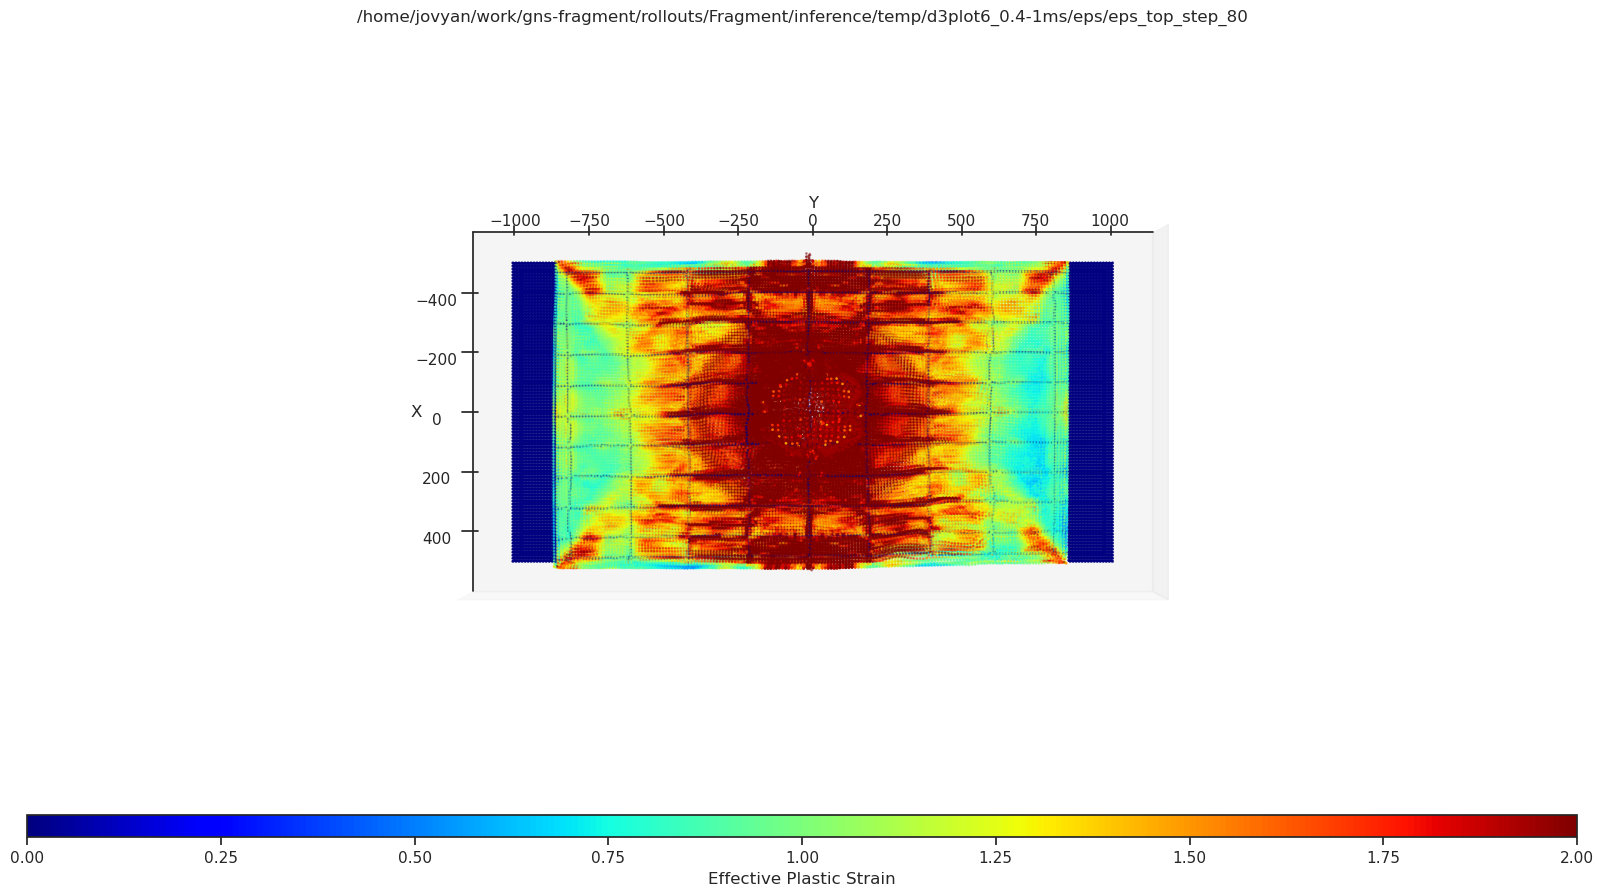

In [400]:
def plot_eps(particle_pos, particle_strain, particle_type, eps_bug_mask, view, savename):
    fig = plt.figure(figsize=(20, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Apply mask for particle type
    mask = particle_type == 1
    particle_strain[mask] = 0
        
    # Scatter plot colored by strain values
    sc = ax.scatter(particle_pos[~eps_bug_mask, 0], particle_pos[~eps_bug_mask, 1], particle_pos[~eps_bug_mask, 2], s=1, c=particle_strain[~eps_bug_mask], vmin=0, vmax=2, cmap='jet')

    # Setting the aspect ratio of the plot to be equal
    ax.set_box_aspect([np.ptp(a) for a in particle_pos.T])

    # Remove grid, ticks, and labels
    ax.set_title(savename)
    ax.grid(False)
    ax.set_zticklabels([])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('')

    # Hide the Z-axis
    ax.zaxis.line.set_lw(0)
    ax.set_zticks([])

    # Adjust the margin between the axis ticks and labels
    ax.tick_params(axis='both', which='major', pad=8)

    # Adding a colorbar
    cbar = plt.colorbar(sc, orientation='horizontal', pad=0., aspect=70)
    cbar.set_label('Effective Plastic Strain')

    # Changing the view angle
    elev = -90 if 'bot' in view else 90
    ax.view_init(elev=elev, azim=0)


start_time = time.time()
case = 'd3plot6'
path = f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/{case}.pkl'

case_dir = Path(f'/home/jovyan/work/gns-fragment/rollouts/Fragment/inference/temp/{case}/')
property_dir = case_dir / 'property'
Path(property_dir).mkdir(parents=True, exist_ok=True)

mass_dir = case_dir / 'mass'
Path(mass_dir).mkdir(parents=True, exist_ok=True)

eps_dir = case_dir / 'eps'
Path(eps_dir).mkdir(parents=True, exist_ok=True)

fragment_dir = case_dir / 'fragment'
Path(fragment_dir).mkdir(parents=True, exist_ok=True)

try:
    with open(path, "rb") as file:
        rollout_data = pickle.load(file)
except FileNotFoundError:
    print(f"File {path} not found.")
    
pred_trajs = rollout_data['pred_trajs']
particle_strains = rollout_data['pred_strains']
particle_type = rollout_data['particle_type']
charge_weight = int(case[-1])
mask = compute_particle_mask(pred_trajs[0], charge_weight)
eps_bug_mask = (pred_trajs[0, :, 0] < 250)&(pred_trajs[0, :, 0] > -250)&(pred_trajs[0, :, 1] < 250)&(pred_trajs[0, :, 1] > -250)&(particle_type == 0) & (particle_strains[-1, :] < 1)


for step in range(80, 81, 10):
    masked_particle_position = pred_trajs[step, mask]
    masked_particle_previous_position = pred_trajs[step-1, mask]
    fragments = compute_fragment(masked_particle_position, dist_thres=10.2, max_fragment_size=100)
    fragments_centre, fragments_mass, fragments_diameter, fragments_vel = compute_fragment_property(masked_particle_position, masked_particle_previous_position, fragments)
    #save_property_csv(fragments_centre, fragments_mass, fragments_diameter, fragments_vel, case, step, savename=str(property_dir / f'fragments_properties_step_{step}.csv'))
    
   # mass_distribution = compute_mass_distribution(fragments_mass, fragments_diameter)
   # plot_mass_distribution_bar(mass_distribution, savename=str(mass_dir/ f'mass_step_{step}'))
    #plot_eps(pred_trajs[step], particle_strains[step], particle_type, view='bot', savename=str(eps_dir/ f'eps_bot_step_{step}'))
    plot_eps(pred_trajs[step], particle_strains[step], particle_type, eps_bug_mask, view='top', savename=str(eps_dir/ f'eps_top_step_{step}'))
    #plot_fragment(masked_particle_position, fragments, fragments_vel, savename=str(fragment_dir/ f'fragment_step_{step}'))

elapsed_time = time.time() - start_time
print(f"Took {elapsed_time} to finish {case}")

In [265]:
# Fragment centre, mass, diameter, velocity
# mass-diameter distribution figure last step
# eps-top figure, eps-bottom figure
# fragment visualisation figure

In [ ]:
- connected graph is too expensive to run, kd tree better
- temporal consistency is hard to maintain
- Search slab top will generate unrealistic fragments on surface (as they have no neighbours)